In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#The dataset that is being used
df = pd.read_csv('philadelphia housing data.csv', low_memory=False)


In [3]:
df

,basements,building_code_description,category_code_description,census_tract,central_air,depth,exempt_building,exempt_land,exterior_condition,fireplaces,...,topography,total_area,total_livable_area,type_heater,unit,view_type,year_built,year_built_estimate,zip_code,zoning
0,D,ROW 3 STY MASONRY,Single Family,241,N,67.00,49200,0,4,0,...,F,938.00,1344,A,NaN,I,1895,Y,19144,RSA5
1,NaN,ROW 2 STY MASONRY,Single Family,201,NaN,70.00,0,0,4,0,...,F,1044.00,1190,NaN,NaN,I,1940,Y,19140,RM1
2,H,ROW B/GAR 2 STY MASONRY,Single Family,281,N,95.50,0,0,4,0,...,F,1686.53,1633,B,NaN,I,1940,Y,19141,RSA3
3,NaN,ROW 2 STY MASONRY,Single Family,293,NaN,112.50,0,0,4,0,...,F,2165.62,1320,B,NaN,I,1940,Y,19124,RSA5
4,NaN,ROW 2 STY MASONRY,Single Family,62,NaN,79.00,0,0,4,0,...,F,1264.00,960,NaN,NaN,I,1920,NaN,19142,RM1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68480,A,DET W/B GAR 1 STY MASONRY,Single Family,257,Y,39.66,0,0,3,0,...,F,6213.00,1360,A,NaN,I,1950,Y,19118,RSD3
68481,D,ROW 3 STY MASONRY,Single Family,378,Y,50.00,0,0,2,0,...,F,736.50,1635,A,NaN,I,1875,Y,19125,RSA5
68482,D,ROW 2 STY MASONRY,Single Family,41,N,48.00,0,0,5,0,...,F,672.00,900,A,NaN,I,1925,Y,19148,RSA5
68483,C,ROW 3 STY MASONRY,Single Family,140,N,62.00,0,0,4,0,...,F,868.00,1722,B,NaN,I,1920,Y,19130,RM1


In [4]:
df['central_air'] = df['central_air'].fillna('N')
df['basements'] = df['basements'].fillna('None')

# Feature Engineering: Creating a log transformation of 'market_value'
df['log_market_value'] = np.log1p(df['market_value'])

# Selecting features for the model
features = ['total_livable_area', 'log_market_value', 'number_of_bathrooms']  # Example features
X = df[features]
y = df['sale_price']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dropping the 'unit' column from the DataFrame
df = df.drop(columns=['unit'])






In [5]:
# Select only the numeric columns from the DataFrame
numeric_cols = df.select_dtypes(include=[np.number])

# Calculate Q1 and Q3 for all numeric columns
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)

# Compute the IQR by subtracting Q1 from Q3
IQR = Q3 - Q1

# Define the criteria for an outlier (values outside 1.5 * IQR from Q1 and Q3)
outlier_criteria = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))

# Any column that has outliers will flag the row as True
rows_with_outliers = outlier_criteria.any(axis=1)

# Filter out the rows with outliers
df_clean = df[~rows_with_outliers]

# Display the shape of the original and cleaned DataFrame to see how many rows were removed
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_clean.shape}")



Original DataFrame shape: (68485, 41)
Cleaned DataFrame shape: (31156, 41)


In [6]:
df

,basements,building_code_description,category_code_description,census_tract,central_air,depth,exempt_building,exempt_land,exterior_condition,fireplaces,...,topography,total_area,total_livable_area,type_heater,view_type,year_built,year_built_estimate,zip_code,zoning,log_market_value
0,D,ROW 3 STY MASONRY,Single Family,241,N,67.00,49200,0,4,0,...,F,938.00,1344,A,I,1895,Y,19144,RSA5,11.922389
1,None,ROW 2 STY MASONRY,Single Family,201,N,70.00,0,0,4,0,...,F,1044.00,1190,NaN,I,1940,Y,19140,RM1,10.778977
2,H,ROW B/GAR 2 STY MASONRY,Single Family,281,N,95.50,0,0,4,0,...,F,1686.53,1633,B,I,1940,Y,19141,RSA3,11.552156
3,None,ROW 2 STY MASONRY,Single Family,293,N,112.50,0,0,4,0,...,F,2165.62,1320,B,I,1940,Y,19124,RSA5,11.085230
4,None,ROW 2 STY MASONRY,Single Family,62,N,79.00,0,0,4,0,...,F,1264.00,960,NaN,I,1920,NaN,19142,RM1,11.098939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68480,A,DET W/B GAR 1 STY MASONRY,Single Family,257,Y,39.66,0,0,3,0,...,F,6213.00,1360,A,I,1950,Y,19118,RSD3,12.883601
68481,D,ROW 3 STY MASONRY,Single Family,378,Y,50.00,0,0,2,0,...,F,736.50,1635,A,I,1875,Y,19125,RSA5,12.551083
68482,D,ROW 2 STY MASONRY,Single Family,41,N,48.00,0,0,5,0,...,F,672.00,900,A,I,1925,Y,19148,RSA5,11.348063
68483,C,ROW 3 STY MASONRY,Single Family,140,N,62.00,0,0,4,0,...,F,868.00,1722,B,I,1920,Y,19130,RM1,11.883806


In [7]:
# Creating a new feature: House Age
df['house_age'] = 2023 - df['year_built']

In [8]:
df

,basements,building_code_description,category_code_description,census_tract,central_air,depth,exempt_building,exempt_land,exterior_condition,fireplaces,...,total_area,total_livable_area,type_heater,view_type,year_built,year_built_estimate,zip_code,zoning,log_market_value,house_age
0,D,ROW 3 STY MASONRY,Single Family,241,N,67.00,49200,0,4,0,...,938.00,1344,A,I,1895,Y,19144,RSA5,11.922389,128
1,None,ROW 2 STY MASONRY,Single Family,201,N,70.00,0,0,4,0,...,1044.00,1190,NaN,I,1940,Y,19140,RM1,10.778977,83
2,H,ROW B/GAR 2 STY MASONRY,Single Family,281,N,95.50,0,0,4,0,...,1686.53,1633,B,I,1940,Y,19141,RSA3,11.552156,83
3,None,ROW 2 STY MASONRY,Single Family,293,N,112.50,0,0,4,0,...,2165.62,1320,B,I,1940,Y,19124,RSA5,11.085230,83
4,None,ROW 2 STY MASONRY,Single Family,62,N,79.00,0,0,4,0,...,1264.00,960,NaN,I,1920,NaN,19142,RM1,11.098939,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68480,A,DET W/B GAR 1 STY MASONRY,Single Family,257,Y,39.66,0,0,3,0,...,6213.00,1360,A,I,1950,Y,19118,RSD3,12.883601,73
68481,D,ROW 3 STY MASONRY,Single Family,378,Y,50.00,0,0,2,0,...,736.50,1635,A,I,1875,Y,19125,RSA5,12.551083,148
68482,D,ROW 2 STY MASONRY,Single Family,41,N,48.00,0,0,5,0,...,672.00,900,A,I,1925,Y,19148,RSA5,11.348063,98
68483,C,ROW 3 STY MASONRY,Single Family,140,N,62.00,0,0,4,0,...,868.00,1722,B,I,1920,Y,19130,RM1,11.883806,103


In [9]:
df.columns

Index(['basements', 'building_code_description', 'category_code_description',
       'census_tract', 'central_air', 'depth', 'exempt_building',
       'exempt_land', 'exterior_condition', 'fireplaces', 'frontage', 'fuel',
       'garage_spaces', 'garage_type', 'geographic_ward', 'interior_condition',
       'location', 'market_value', 'market_value_date', 'number_of_bathrooms',
       'number_of_bedrooms', 'number_of_rooms', 'number_stories',
       'quality_grade', 'sale_date', 'sale_price', 'street_designation',
       'street_direction', 'street_name', 'taxable_building', 'taxable_land',
       'topography', 'total_area', 'total_livable_area', 'type_heater',
       'view_type', 'year_built', 'year_built_estimate', 'zip_code', 'zoning',
       'log_market_value', 'house_age'],
      dtype='object')

In [10]:
pf = PolynomialFeatures(degree=2, include_bias=False)
poly_features = pf.fit_transform(df[['total_livable_area', 'total_area']])

# Updated to use get_feature_names_out for compatibility with newer versions of scikit-learn
poly_df = pd.DataFrame(poly_features, columns=pf.get_feature_names_out(['total_livable_area', 'total_area']))
df = pd.concat([df, poly_df], axis=1)


In [11]:
df

,basements,building_code_description,category_code_description,census_tract,central_air,depth,exempt_building,exempt_land,exterior_condition,fireplaces,...,year_built_estimate,zip_code,zoning,log_market_value,house_age,total_livable_area,total_area,total_livable_area^2,total_livable_area total_area,total_area^2
0,D,ROW 3 STY MASONRY,Single Family,241,N,67.00,49200,0,4,0,...,Y,19144,RSA5,11.922389,128,1344.0,938.00,1806336.0,1260672.00,8.798440e+05
1,None,ROW 2 STY MASONRY,Single Family,201,N,70.00,0,0,4,0,...,Y,19140,RM1,10.778977,83,1190.0,1044.00,1416100.0,1242360.00,1.089936e+06
2,H,ROW B/GAR 2 STY MASONRY,Single Family,281,N,95.50,0,0,4,0,...,Y,19141,RSA3,11.552156,83,1633.0,1686.53,2666689.0,2754103.49,2.844383e+06
3,None,ROW 2 STY MASONRY,Single Family,293,N,112.50,0,0,4,0,...,Y,19124,RSA5,11.085230,83,1320.0,2165.62,1742400.0,2858618.40,4.689910e+06
4,None,ROW 2 STY MASONRY,Single Family,62,N,79.00,0,0,4,0,...,NaN,19142,RM1,11.098939,103,960.0,1264.00,921600.0,1213440.00,1.597696e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68480,A,DET W/B GAR 1 STY MASONRY,Single Family,257,Y,39.66,0,0,3,0,...,Y,19118,RSD3,12.883601,73,1360.0,6213.00,1849600.0,8449680.00,3.860137e+07
68481,D,ROW 3 STY MASONRY,Single Family,378,Y,50.00,0,0,2,0,...,Y,19125,RSA5,12.551083,148,1635.0,736.50,2673225.0,1204177.50,5.424322e+05
68482,D,ROW 2 STY MASONRY,Single Family,41,N,48.00,0,0,5,0,...,Y,19148,RSA5,11.348063,98,900.0,672.00,810000.0,604800.00,4.515840e+05
68483,C,ROW 3 STY MASONRY,Single Family,140,N,62.00,0,0,4,0,...,Y,19130,RM1,11.883806,103,1722.0,868.00,2965284.0,1494696.00,7.534240e+05


In [12]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 302854.24234842474
R^2: 0.4182304951775807


In [13]:
# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10)
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
param_distributions=param_distributions,
n_iter=10,  # Number of parameter settings sampled
cv=5,       # 5-fold cross-validation
scoring='neg_root_mean_squared_error',
random_state=42,
n_jobs=-1)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Retrieve the best parameters and the corresponding score
best_params = random_search.best_params_
best_score = -random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (RMSE):", best_score)



Best Parameters: {'max_depth': 30, 'min_samples_split': 8, 'n_estimators': 182}
Best Score (RMSE): 279487.5451051354


In [14]:
# Train the model with best hyperparameters
optimized_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
max_depth=best_params['max_depth'],
min_samples_split=best_params['min_samples_split'],
random_state=42)

optimized_model.fit(X_train, y_train)

# Make predictions with the optimized model
y_pred_optimized = optimized_model.predict(X_test)

# Evaluate the optimized model
rmse_optimized = math.sqrt(mean_squared_error(y_test, y_pred_optimized))
r2_optimized = r2_score(y_test, y_pred_optimized)

print("Optimized RMSE:", rmse_optimized)
print("Optimized R^2:", r2_optimized)


Optimized RMSE: 298128.09172093874
Optimized R^2: 0.4362462679053545


In [15]:
# Get feature importances
feature_importances = optimized_model.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print(features_df)


               Feature  Importance
1     log_market_value    0.670659
0   total_livable_area    0.292884
2  number_of_bathrooms    0.036456


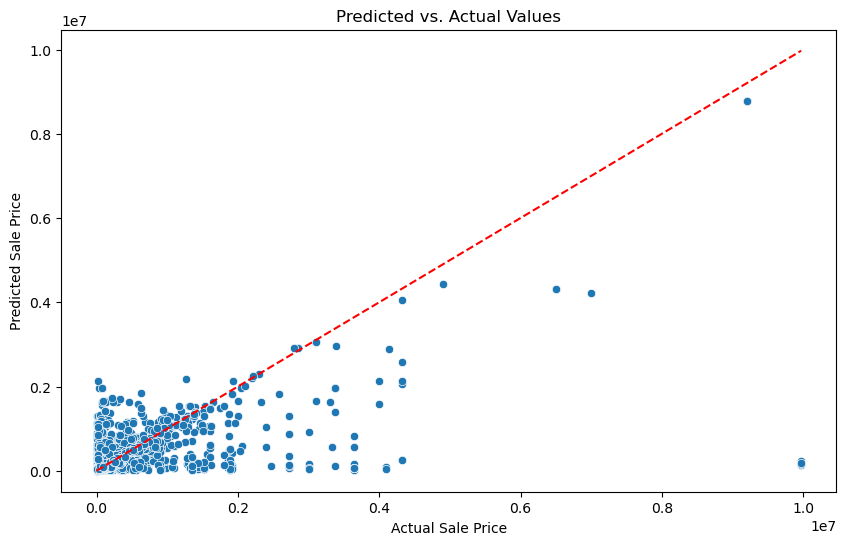

In [16]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_optimized)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()



In [17]:

residuals = y


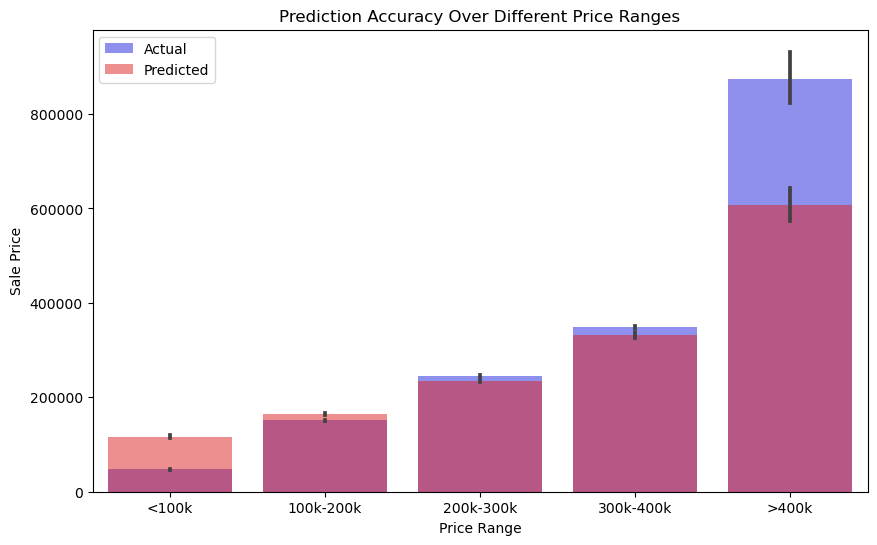

In [18]:
# Binning the data to create price range groups
bins = pd.cut(y_test, bins=[0, 100000, 200000, 300000, 400000, np.inf], labels=['<100k', '100k-200k', '200k-300k', '300k-400k', '>400k'])
# Creating a DataFrame to hold actual and predicted values along with their corresponding price range
accuracy_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_optimized, 'Range': bins})

plt.figure(figsize=(10, 6))
# Plotting actual values as blue bars
sns.barplot(x='Range', y='Actual', data=accuracy_df, color='blue', alpha=0.5, label='Actual')
# Plotting predicted values as red bars
sns.barplot(x='Range', y='Predicted', data=accuracy_df, color='red', alpha=0.5, label='Predicted')
plt.title('Prediction Accuracy Over Different Price Ranges') # Adding title to the plot
plt.xlabel('Price Range') # Labeling x-axis
plt.ylabel('Sale Price') # Labeling y-axis
plt.legend() # Showing legend
plt.show() # Displaying the plot
